In [1]:
#import sys
#sys.path.append("/home/chrhck/repos/hierarchical_nu/software/")
import logging
#logging.basicConfig(level=logging.DEBUG)
from python.detector_model import NorthernTracksDetectorModel
from python.backend.stan_generator import (
    StanGenerator, GeneratedQuantitiesContext, DataContext,
    FunctionsContext, Include, ForLoopContext, StanFileGenerator, WhileLoopContext,TransformedDataContext)
from python.backend.operations import FunctionCall
from python.backend.variable_definitions import ForwardVariableDef, ForwardArrayDef
from python.backend.parameterizations import LogParameterization
from python.backend.expression import StringExpression
from python.backend.parameterizations import DistributionMode

import pystan
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.stats

try:
    import holoviews as hv
    from holoviews import opts
    hv.extension('bokeh', "matplotlib")
except ModuleNotFoundError:
    print("No holoviews")
import seaborn as sns
import h5py

No holoviews


In [2]:
with StanGenerator() as cg:
    with DataContext() as dc:
        
        # Sources
        Ns = ForwardVariableDef("Ns", "int")
        Ns_str = ["[", Ns, "]"]
        Ns_1p_str = ["[", Ns, "+1]"]
        
        varpi = ForwardArrayDef("varpi", "unit_vector[3]", Ns_str)
        
    with TransformedDataContext() as tdc:
        F = ForwardVariableDef("F", "vector[Ns+1]")
        FT = ForwardVariableDef("FT", "real")
        Fs = ForwardVariableDef("Fs", "real")
        f = ForwardVariableDef("f", "real")
        w_exposure = ForwardVariableDef("w_exposure", "simplex[Ns+1]")
        Nex = ForwardVariableDef("Nex", "real")
        N = ForwardVariableDef("N", "int")
    
    with GeneratedQuantitiesContext() as gqc:
        accept = ForwardVariableDef("accept", "int")
        ntrials = ForwardVariableDef("ntrials", "int")
        omega = ForwardVariableDef("omega", "unit_vector[3]")
        N_str = ["[", N, "]"]
        lam = ForwardArrayDef("Lambda", "int", N_str)
        cosz = ForwardArrayDef("cosz", "real", N_str)
        
        with ForLoopContext(1, N, "i") as i:
            accept << 0
            ntrials << 0
            with WhileLoopContext([accept != 1]):
                StringExpression(["if (", lam[i], " < Ns+1) {\n",
                              omega, " = ", varpi[lam[i]], ";\n",
                              #omega, " = sphere_rng(1);\n"
                              "}\n", "else if (", lam[i], " == Ns+1) {\n", 
                              omega, " = sphere_rng(1);\n"])


            cosz[i] << StringExpression(["cos(omega_to_zenith(", omega, "))"])
    

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x1136f9cd0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x1136f9bd0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x1136f9e90> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x10271e890> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11370a150> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11370a050> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11370a0d0> already on stack
INFO:python.backend.code_ge

In [3]:
print(cg.generate())

data
{
int Ns;
unit_vector[3] varpi[Ns];
}
transformed data
{
vector[Ns+1] F;
real FT;
real Fs;
real f;
simplex[Ns+1] w_exposure;
real Nex;
int N;
F;
FT;
Fs;
f;
w_exposure;
Nex;
}
generated quantities
{
int accept;
int ntrials;
unit_vector[3] omega;
int Lambda[N];
real cosz[N];
for (i in 1:N)
{
accept = 0;
ntrials = 0;
while((accept!=1))
{
if (Lambda[i] < Ns+1) {
omega = varpi[Lambda[i]];
}
else if (Lambda[i] == Ns+1) {
omega = sphere_rng(1);
;
}
cosz[i] = cos(omega_to_zenith(omega));
}
}



# Create stan files for the detector model

In [4]:
with StanFileGenerator("stan_files/detector_model_test") as cg:   
    ntd = NorthernTracksDetectorModel()    
    cg.generate_files()
    

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x112ada7d0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x1136f9410> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11370a590> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11370a950> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11370afd0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11370a8d0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x102700fd0> already on stack
INFO:python.backend.code_gener

# Plot detector model distributions

In [5]:
e_true_name = "e_trues"
e_reco_name = "e_recos"
true_dir_name = "true_dirs"
reco_zenith_name = "reco_zeniths"

with StanGenerator() as cg:

    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("vMF.stan")

    with DataContext() as dc:
        array_length = ForwardVariableDef("n", "int")
        array_length_str = ["[", array_length, "]"]
        
        e_trues = ForwardArrayDef(e_true_name, "real", array_length_str)
        e_recos = ForwardArrayDef(e_reco_name, "real", array_length_str)
        true_dirs = ForwardArrayDef(true_dir_name, "vector[3]", array_length_str)
        reco_zenith = ForwardArrayDef(reco_zenith_name, "real", array_length_str)

    with GeneratedQuantitiesContext() as gq:
        ntd = NorthernTracksDetectorModel()

        array_length_2d_str = ["[", array_length, ",", array_length, "]"]
        e_res_result = ForwardArrayDef("e_res", "real", array_length_2d_str)
        eff_area_result = ForwardArrayDef("eff_area", "real", array_length_2d_str)
        ang_res_result = ForwardArrayDef("ang_res", "real", array_length_2d_str)

        
        reco_dir_ang_res = ForwardVariableDef("reco_dir", "vector[3]")        
        true_dir_ang_res = ForwardVariableDef("true_dir", "vector[3]")
        true_dir_ang_res << StringExpression("[sin(pi()/2), 0, cos(pi()/2)]'")
        
        with ForLoopContext(1, array_length, "i") as i:
            with ForLoopContext(1, array_length, "j") as j:
                eff_area_result[i][j] << ntd.effective_area(e_trues[i], true_dirs[j])       
                e_res_result[i][j] << ntd.energy_resolution(e_trues[i], e_recos[j])
                reco_dir_ang_res << StringExpression(["[sin(", reco_zenith[j], "), 0, cos(", reco_zenith[j],")]'"])
                ang_res_result[i][j] << ntd.angular_resolution(e_trues[i], true_dir_ang_res, reco_dir_ang_res)
    model = cg.generate()

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x113738050> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x1136eb890> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x112a4cb10> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x113738350> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x113738510> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x113738a50> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x113738f90> already on stack
INFO:python.backend.code_gener

In [6]:
this_dir = os.path.abspath('')
sm = pystan.StanModel(
    model_code=model,
    include_paths=[os.path.join(this_dir, "../dev/statistical_model/4_tracks_and_cascades/stan/")],
    verbose=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4ea85a1afc30b353114f3c540a641e7b NOW.


In [7]:
n = 100
e_reco = np.logspace(2, 9, n)
e_true = np.logspace(2, 7, n)
reco_zeniths = np.radians(np.linspace(85, 95, n))
thetas = np.pi - np.radians(np.linspace(85, 180, n, endpoint=False))
true_dir = np.asarray([np.sin(thetas), np.zeros_like(thetas), np.cos(thetas)]).T

data = {
    e_true_name: e_reco,
    e_reco_name: e_true,
    true_dir_name: true_dir,
    reco_zenith_name: reco_zeniths,
    "n": n
    #"reco_dir": dir2
}
fit = sm.sampling(data=data, iter=1, chains=1, algorithm="Fixed_param")


In [8]:
thetas

array([1.65806279, 1.64148216, 1.62490153, 1.60832091, 1.59174028,
       1.57515965, 1.55857902, 1.54199839, 1.52541777, 1.50883714,
       1.49225651, 1.47567588, 1.45909525, 1.44251463, 1.425934  ,
       1.40935337, 1.39277274, 1.37619212, 1.35961149, 1.34303086,
       1.32645023, 1.3098696 , 1.29328898, 1.27670835, 1.26012772,
       1.24354709, 1.22696646, 1.21038584, 1.19380521, 1.17722458,
       1.16064395, 1.14406332, 1.1274827 , 1.11090207, 1.09432144,
       1.07774081, 1.06116019, 1.04457956, 1.02799893, 1.0114183 ,
       0.99483767, 0.97825705, 0.96167642, 0.94509579, 0.92851516,
       0.91193453, 0.89535391, 0.87877328, 0.86219265, 0.84561202,
       0.82903139, 0.81245077, 0.79587014, 0.77928951, 0.76270888,
       0.74612826, 0.72954763, 0.712967  , 0.69638637, 0.67980574,
       0.66322512, 0.64664449, 0.63006386, 0.61348323, 0.5969026 ,
       0.58032198, 0.56374135, 0.54716072, 0.53058009, 0.51399946,
       0.49741884, 0.48083821, 0.46425758, 0.44767695, 0.43109

/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


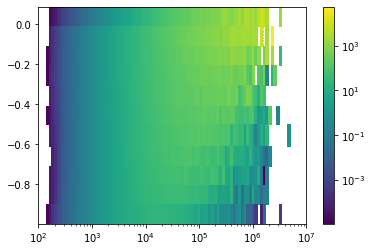

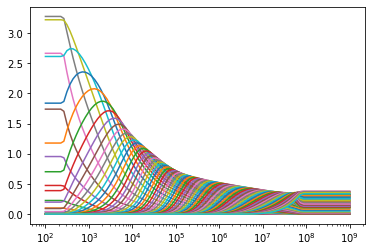

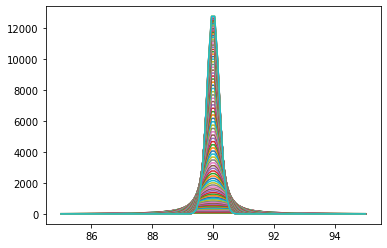

In [9]:
plt.pcolormesh(e_true, np.cos(np.pi - thetas), fit.extract()["eff_area"].squeeze().T,
              norm=LogNorm())
plt.colorbar()
plt.semilogx()
plt.figure()
_ =plt.plot(e_reco, np.exp(fit.extract()["e_res"].squeeze()))
plt.semilogx()

plt.figure()
_ =plt.plot(np.degrees(reco_zeniths), np.exp(fit.extract()["ang_res"].squeeze()).T)

In [ ]:
ang_res_e = np.exp(fit.extract()["ang_res_e"].squeeze())
obs = hv.HoloMap({np.log10(e_true[i]): hv.Curve((np.degrees(reco_zeniths), ang_res_e[i])) for i in range(100)}, kdims='Energy')
obs

In [ ]:
e_res_e = np.exp(fit.extract()["e_res"].squeeze())
obs = hv.HoloMap({np.log10(e_true[i]): hv.Curve((np.log10(e_reco), e_res_e[i])) for i in range(100)}, kdims='Energy')
obs

In [20]:
e_true_name = "e_trues"
true_dir_name = "true_dirs"


with StanGenerator() as cg:

    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("vMF.stan")

    with DataContext() as dc:
        array_length_e = ForwardVariableDef("nE", "int")
        array_length_z = ForwardVariableDef("nZ", "int")
        array_length_str_e = ["[", array_length_e, "]"]
        array_length_str_z = ["[", array_length_z, "]"]
        
        e_trues = ForwardArrayDef(e_true_name, "real", array_length_str_e)
        true_dirs = ForwardArrayDef(true_dir_name, "vector[3]", array_length_str_z)


    with GeneratedQuantitiesContext() as gq:
        ntd = NorthernTracksDetectorModel()

        array_length_2d_str = ["[", array_length_e, ",", array_length_z, "]"]
        
        eff_area_result = ForwardArrayDef("eff_area", "real", array_length_2d_str)
        
        with ForLoopContext(1, array_length_e, "i") as i:
            with ForLoopContext(1, array_length_z, "j") as j:
                eff_area_result[i][j] << ntd.effective_area(e_trues[i], true_dirs[j])       
    model = cg.generate()
this_dir = os.path.abspath('')
sm = pystan.StanModel(
    model_code=model,
    include_paths=[os.path.join(this_dir, "../dev/statistical_model/4_tracks_and_cascades/stan/")],
    verbose=False)

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x114abd890> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x114aef310> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x114acee50> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x114abddd0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x114abd350> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x114ac5750> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x114acfd50> already on stack
INFO:python.backend.code_gener

In [11]:
with h5py.File("../dev/statistical_model/4_tracks_and_cascades/aeff_input_tracks/effective_area.h5", 'r') as f:
    area10 = f['2010/nu_mu/area'][()]
    tE_bin_edges = f['2010/nu_mu/bin_edges_0'][:] # True Energy [GeV]
    cosz_bin_edges = f['2010/nu_mu/bin_edges_1'][:] # cos(zenith)
    rE_bin_edges = f['2010/nu_mu/bin_edges_2'][:] # Reco Energy [GeV]
    
tE_binc = 0.5*(tE_bin_edges[:-1]+tE_bin_edges[1:])
rE_binc = 0.5*(rE_bin_edges[:-1]+rE_bin_edges[1:])
cosz_binc = 0.5*(cosz_bin_edges[:-1]+cosz_bin_edges[1:])

In [12]:
e_true = tE_binc 
thetas = np.pi - np.arccos(cosz_binc)
true_dir = np.asarray([np.sin(thetas), np.zeros_like(thetas), np.cos(thetas)]).T

data = {
    e_true_name: e_true,
    true_dir_name: true_dir,
    "nE": len(tE_binc),
    "nZ": len(cosz_binc)
}
fit = sm.sampling(data=data, iter=1, chains=1, algorithm="Fixed_param")


/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


[]

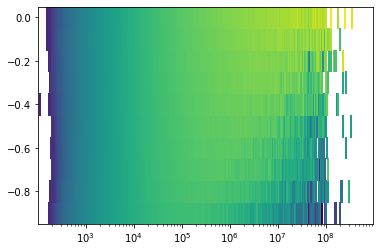

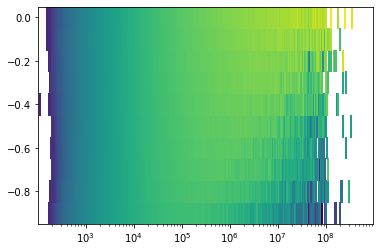

In [13]:
plt.pcolormesh(e_true, np.cos(np.pi - thetas), fit.extract()["eff_area"].squeeze().T,
              norm=LogNorm())
plt.semilogx()
plt.figure()
plt.pcolormesh(tE_binc, cosz_binc, area10.sum(axis=2).T,
               norm=LogNorm())
plt.semilogx()

Test RV Generation
==================

In [21]:
with StanFileGenerator("stan_files/detector_model_test") as cg:   
    ntd_rng = NorthernTracksDetectorModel(mode=DistributionMode.RNG)
    ntd_pdf = NorthernTracksDetectorModel(mode=DistributionMode.PDF) 
    cg.generate_files()

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x1141f76d0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x114abac50> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x1180d5190> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x114203910> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x114aefe50> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x114abd550> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x114af6410> already on stack
INFO:python.backend.code_gener

In [22]:
with StanGenerator() as cg:
    with FunctionsContext() as fc:
        Include("utils.stan")
        Include("vMF.stan")
        #Include("detector_model_test_functions.stan")
        
    with DataContext() as dc:
        true_energy = ForwardVariableDef("true_energy", "real")
        true_dir = ForwardVariableDef("true_dir", "vector[3]")
        
    with GeneratedQuantitiesContext() as gq:
        ntd_rng = NorthernTracksDetectorModel(mode=DistributionMode.RNG)
        ntd_pdf = NorthernTracksDetectorModel(mode=DistributionMode.PDF) 
        rec_energy = ForwardVariableDef("rec_energy", "real")
        rec_dir = ForwardVariableDef("rec_dir", "vector[3]") 
        # rec_energy_lh = ForwardVariableDef("rec_energy_lh", "real")
        # rec_dir_lh = ForwardVariableDef("rec_dir_lh", "real")
        
        rec_energy << ntd_rng.energy_resolution(true_energy)
        rec_dir << ntd_rng.angular_resolution(true_energy, true_dir)
        # rec_energy_lh << ntd_pdf.energy_resolution(true_energy, 10**rec_energy)
        # rec_dir_lh << ntd_pdf.angular_resolution(true_energy, true_dir, rec_dir)
        
    model = cg.generate()
    
    
with StanGenerator() as cg:
    with FunctionsContext() as fc:
        Include("utils.stan")
        Include("vMF.stan")
    
    with DataContext() as dc:
        true_energy = ForwardVariableDef("true_energy", "real")              
        e_recos = ForwardArrayDef("e_recos", "real", ["[100]"])
    
    with GeneratedQuantitiesContext() as gq:
        e_res_result = ForwardArrayDef("e_res", "real", ["[100]"])
        ntd_pdf = NorthernTracksDetectorModel(mode=DistributionMode.PDF) 
        with ForLoopContext(1, 100, "i") as i:
            e_res_result[i] << ntd_pdf.energy_resolution(true_energy, e_recos[i])
        
    model2 = cg.generate()

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x113e87e50> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x114a34910> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x113e87f50> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x113f3cd90> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x113f3c9d0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x113f3c910> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x113f3c410> already on stack
INFO:python.backend.code_gener

In [23]:
this_dir = os.path.abspath('')
sm = pystan.StanModel(
    model_code=model,
    include_paths=[
        os.path.join(this_dir, "stan_files"),
        os.path.join(this_dir, "../dev/statistical_model/4_tracks_and_cascades/stan/")],
    verbose=False)

this_dir = os.path.abspath('')
sm2 = pystan.StanModel(
    model_code=model2,
    include_paths=[
        os.path.join(this_dir, "stan_files"),
        os.path.join(this_dir, "../dev/statistical_model/4_tracks_and_cascades/stan/")],
    verbose=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cb0c8d5a70f3d92c4b340548b26fb490 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f6e5ba0f3079ab1c7d2f9980f6eaa04d NOW.


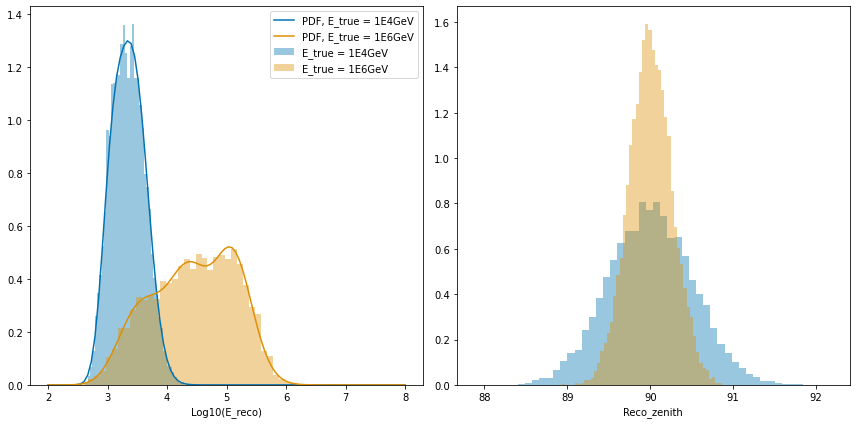

In [24]:
zenith = np.pi/2

fix, axs = plt.subplots(1, 2, figsize=(12, 6))

data = {"true_energy": 1E4,
        "true_dir":[np.sin(zenith), 0, np.cos(zenith)],
        "e_recos" : np.logspace(2, 8, 100)}

colors = sns.color_palette("colorblind")

fit = sm.sampling(data=data, iter=10000, chains=1, algorithm="Fixed_param")
fit2 = sm2.sampling(data=data, iter=1, chains=1, algorithm="Fixed_param")
sns.distplot(fit["rec_energy"], ax=axs[0], label="E_true = 1E4GeV", kde=False, norm_hist=True, color=colors[0])
sns.distplot(np.degrees(np.arccos(fit["rec_dir"][:, 2])), ax=axs[1], kde=False, norm_hist=True, color=colors[0])
axs[0].plot(np.log10(data["e_recos"]), np.exp(fit2.extract()["e_res"].squeeze()), color=colors[0], label="PDF, E_true = 1E4GeV")

data = {"true_energy": 1E6,
        "true_dir":np.asarray([np.sin(zenith), 0, np.cos(zenith)]).T,
        "e_recos" : np.logspace(2, 8, 100)}

fit = sm.sampling(data=data, iter=10000, chains=1, algorithm="Fixed_param")
fit2 = sm2.sampling(data=data, iter=1, chains=1, algorithm="Fixed_param")
sns.distplot(fit["rec_energy"], ax=axs[0], label="E_true = 1E6GeV", kde=False, norm_hist=True, color=colors[1])
sns.distplot(np.degrees(np.arccos(fit["rec_dir"][:, 2])), ax=axs[1], kde=False, norm_hist=True, color=colors[1])
axs[0].plot(np.log10(data["e_recos"]), np.exp(fit2.extract()["e_res"].squeeze()), color=colors[1], label="PDF, E_true = 1E6GeV")



axs[0].set_xlabel("Log10(E_reco)")
axs[1].set_xlabel("Reco_zenith")
axs[0].legend(loc="upper right")
plt.tight_layout()
plt.savefig("rng_crosscheck.png", dpi=200)


# Test source sampling functions

In [68]:
from python.source.simple_source import PointSource, DiffuseSource, TestSourceList
from python.source.flux_model import PowerLawSpectrum, IsotropicDiffuseBG
from python.source.parameter import Parameter
Parameter.clear_registry()
from python.source.atmospheric_flux import AtmosphericNuMuFlux
from python.backend.stan_generator import (ParametersContext, 
                                           TransformedParametersContext, ModelContext)
from python.backend.variable_definitions import ParameterDef, ParameterVectorDef

import stan_utility

from astropy import units as u

In [63]:
# Atmo flux
atmo_bg_flux = AtmosphericNuMuFlux(1E2 * u.GeV, 1E9 * u.GeV)
atmo_bg_flux.total_flux_int

<Quantity 0.30188677 1 / (m2 s)>

In [64]:
# Diffuse flux
diffuse_norm = Parameter(1.44E-14 /u.GeV/u.m**2/u.s, "diffuse_norm", fixed=True, 
                         par_range=(0, np.inf))
diffuse_flux_model = IsotropicDiffuseBG(PowerLawSpectrum(diffuse_norm, 1E5*u.GeV, 
                                                         index, lower_energy=1E2*u.GeV, 
                                                         upper_energy=1E8*u.GeV))

In [65]:
# Point source
lumi = Parameter(5E51 * (u.erg / u.s), "luminosity", fixed=True, 
                       par_range=(0, 1E60))
index = Parameter(2.0, "index", fixed=False, par_range=(1.1, 4))
source = PointSource.make_powerlaw_source(
    "test", 1*u.rad, 2*u.rad, lumi, index, 1, 1E2*u.GeV, 1E9*u.GeV)
print(source.luminosity)
print(source.parameters["norm"])

5e+51 erg / s
Parameter test_norm = 3.7011676845929974e-11 1 / (GeV m2 s)


In [69]:
Ns = 100000
with StanFileGenerator("stan_files/test") as cg:
    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("interpolation.stan")
    
    
    spectrum_rng = source.flux_model.spectral_shape.make_stan_sampling_func("spectrum_rng")
    diffuse_flux_rng = diffuse_flux_model.make_stan_sampling_func("diffuse_bg_rng")
    atmu_nu_flux = atmo_bg_flux.make_stan_function(theta_points=30)
        
    with ParametersContext():
        energy = ParameterDef("energy", "real", 1E2, 1E9)
        coszen = ParameterDef("coszen", "real", -1, 1) 
        
    with TransformedParametersContext():
        omega = ForwardVariableDef("omega", "vector[3]")
        zen = ForwardVariableDef("zen", "real")
        sinzen = ForwardVariableDef("sinzen", "real")
        
        zen << FunctionCall([coszen], "acos")
        sinzen  << FunctionCall([zen], "sin")
        
        omega[1] << sinzen
        omega[2] << 0
        omega[3] << coszen
        
    with ModelContext():
        
        logflux = FunctionCall([atmu_nu_flux(energy, omega)], "log")
        StringExpression(["target += ", logflux])
        
    with GeneratedQuantitiesContext():
        pl_samples = ForwardVariableDef("pl_samples", "real")
        diffuse_events = ForwardVariableDef("diffuse_events", "vector[3]") 

        #with ForLoopContext(1, Ns, "i") as i:
        pl_samples << spectrum_rng(2, 1E2, 1E9)
        diffuse_events << diffuse_flux_rng(2, 1E2, 1E9)
        
model = cg.generate_single_file()

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x118018f90> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x1157a4f90> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x114885a10> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x114885110> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x117d7a690> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x114c0bfd0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x115ac9d90> already on stack
INFO:python.backend.code_genera

In [70]:
# Compile
this_dir = os.path.abspath('')
include_paths = [os.path.join(this_dir, 
                              "../dev/statistical_model/4_tracks_and_cascades/stan/")]

sm = stan_utility.compile_model(filename=cg.filename, include_paths=include_paths, 
                                model_name="test")

Using cached StanModel


In [71]:
simulation = sm.sampling(data={}, iter=1000, chains=1, 
                         algorithm="NUTS")

#### Diffuse events

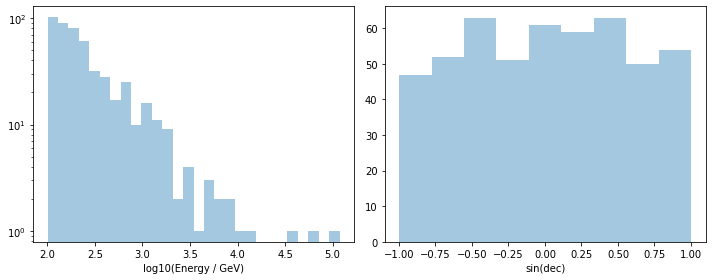

In [72]:
events = simulation.extract(["diffuse_events"])["diffuse_events"]
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.distplot(np.log10(events[:, 0]), kde=False, ax = axs[0])
axs[0].set_yscale("log")
axs[0].set_xlabel("log10(Energy / GeV)")
axs[1].set_xlabel("sin(dec)")
sns.distplot(np.sin(events[:, 1]), kde=False, ax = axs[1])
plt.tight_layout()

#### Atmo events

[]

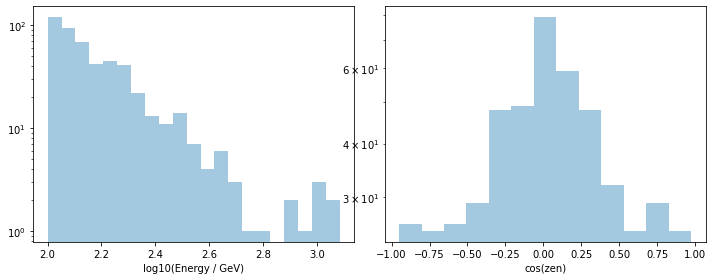

In [73]:
atmo_events = simulation.extract(["energy", "coszen"])
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.distplot(np.log10(atmo_events["energy"]), kde=False, ax = axs[0])
axs[0].set_yscale("log")
axs[0].set_xlabel("log10(Energy / GeV)")
axs[1].set_xlabel("cos(zen)")
sns.distplot(atmo_events["coszen"], kde=False, ax = axs[1])
plt.tight_layout()
plt.semilogy()

#### Compare sampled energies to true spectrum integrated over dOmega

In [74]:
np.sin(-np.pi/2)

-1.0

[]

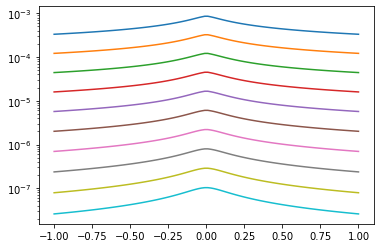

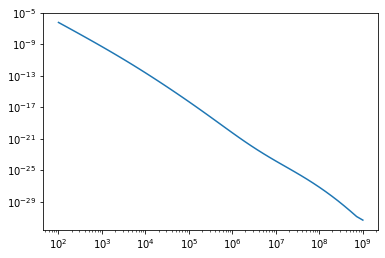

In [75]:
energies = np.logspace(2, 9, 50)
coszens = np.linspace(-1, 1, 100)

dec = -np.arcsin(coszens)
for e in energies[:10]:
    plt.plot(coszens, atmo_bg_flux(e * u.GeV, dec * u.rad, 0*u.rad))
plt.semilogy()
plt.figure()

plt.plot(energies, atmo_bg_flux.total_flux(energies * u.GeV))
plt.loglog()

Text(0, 0.5, 'Prob. per log bin')

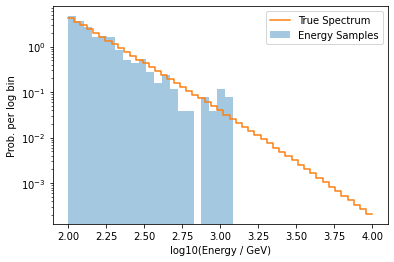

In [76]:
energies = np.logspace(2, 9, 100) << u.GeV
log_bins = np.linspace(2, 4, 50) 

integrate_per_log = atmo_bg_flux.integral(
    10**log_bins[:-1] * u.GeV, 10**log_bins[1:] * u.GeV,
    (-np.pi/2) * u.rad, (np.pi/2) * u.rad,
    0 * u.rad, 2*np.pi * u.rad) / np.diff(log_bins) / atmo_bg_flux.total_flux_int

fluxes = atmo_bg_flux.total_flux(energies) / atmo_bg_flux.total_flux_int

sns.distplot(np.log10(atmo_events["energy"]), kde=False, norm_hist=True, label="Energy Samples")
plt.step(log_bins, np.append(integrate_per_log, integrate_per_log[-1]), where="post", label="True Spectrum")
plt.semilogy()
plt.legend()
plt.xlabel("log10(Energy / GeV)")
plt.ylabel("Prob. per log bin")